In [1]:
# !pip install ipympl
# pip install black isort jupyterlab-code-formatter

In [2]:
%matplotlib widget
import itertools as iter
import math

import cupy as cp
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.linalg.blas as sblas
import sympy as sy
from sympy.plotting import plot

cp.cuda.Device(), cp.cuda.device.get_compute_capability(), cp.cuda.get_current_stream()

(<CUDA Device 0>, '86', <Stream 0 (device -1)>)

In [3]:
x_cpu = np.array([1, 2, 3])
y_cpu = np.array([4, 5, 6])
x_gpu = cp.asarray(x_cpu)

In [4]:
cp.asnumpy(x_gpu) + y_cpu

array([5, 7, 9])

In [5]:
x_gpu + cp.asarray(y_cpu)

array([5, 7, 9])

In [6]:
sg_all = cp.asarray([])
s_cpall = cp.asnumpy(sg_all)

In [7]:
# plt.plot([1, 34, 23, 55, 8])
# plt.show()

In [8]:
import cupy

x = cupy.array(range(9)).reshape((3, 3))
y = cupy.array(range(9, 18)).reshape((3, 3))
expected = cupy.matmul(x, y)
cupy.cuda.Device().synchronize()

stream = cupy.cuda.stream.Stream()
with stream:
    for k in range(10000):
        z = cupy.matmul(x, y)
stream.synchronize()
cupy.testing.assert_array_equal(z, expected)

stream = cupy.cuda.stream.Stream()
stream.use()
z = cupy.matmul(x, y)
stream.synchronize()
cupy.testing.assert_array_equal(z, expected)
z

array([[ 42,  45,  48],
       [150, 162, 174],
       [258, 279, 300]])

In [9]:
# https://docs.cupy.dev/en/stable/user_guide/kernel.html
# EXAMPLE
kernel = cp.ElementwiseKernel(
    "T x, T y",
    "T z",
    """
     if (x - 2 > y) {
       z = x * y;
     } else {
       z = x + y;
     }
     """,
    "my_kernel",
)

x = cp.arange(6, dtype="d").reshape(2, 3)
y = cp.arange(3, dtype="d")
kernel(x, y)

array([[ 0.,  2.,  4.],
       [ 0.,  4., 10.]])

In [10]:
# EXAMPLE
add_kernel = cp.RawKernel(
    r"""
typedef float T;

extern "C" __global__
void my_add(const T* x1, const T* x2, T* y) {
    int tid = blockDim.x * blockIdx.x + threadIdx.x;
    y[tid] = x1[tid] + x2[tid];
}
""",
    "my_add",
)
x1 = cp.arange(25, dtype=cp.float32).reshape(5, 5)
x2 = cp.arange(25, dtype=cp.float32).reshape(5, 5)
y = cp.zeros((5, 5), dtype=cp.float32)
add_kernel((5,), (5,), (x1, x2, y))  # grid, block and arguments

y

array([[ 0.,  2.,  4.,  6.,  8.],
       [10., 12., 14., 16., 18.],
       [20., 22., 24., 26., 28.],
       [30., 32., 34., 36., 38.],
       [40., 42., 44., 46., 48.]], dtype=float32)

In [11]:
# cp.cuda.Device().attributes

In [12]:
# Float type to use. Update CUDA kernels when changing this.
dtype = cp.float64
n = 5  # Number of scalar values in a measurement
p = 4  # Max moment degree to calc

In [13]:
ck_powers = cp.RawKernel(
    r"""
typedef double T;

extern "C" __global__
void powers(const int p, const T* x, T* y) {
    const int tid = blockDim.x * blockIdx.x + threadIdx.x;
    const T z = x[tid];
    T c = z;
    int n = p;
    int i = tid * p;
    while (true) {
        // printf("<%d (b=%d, t=%d)> [%d] at %d = %f # %d\n", tid, blockIdx.x, threadIdx.x, i, n, c, p);
        y[i++] = c;
        if (n <= 1) break;
        n--;
        c *= z;
    }
}
""",
    "powers",
)
ck_powers.attributes

{'max_threads_per_block': 1024,
 'shared_size_bytes': 0,
 'const_size_bytes': 0,
 'local_size_bytes': 0,
 'num_regs': 38,
 'ptx_version': 86,
 'binary_version': 86,
 'cache_mode_ca': 0,
 'max_dynamic_shared_size_bytes': 49152,
 'preferred_shared_memory_carveout': -1}

In [14]:
try:
    x = cp.arange(n, dtype=dtype) + 1
    print(x)
    x_powers = cp.zeros((n, p), dtype=dtype)

    bs = min(ck_powers.max_threads_per_block, n)
    b = n // bs
    if n % bs != 0:
        b += 1
    print(b, bs)

    ck_powers(
        (b,), (bs,), (p, x, x_powers)
    )  # grid (number of blocks), block and arguments
    print(x_powers)
finally:
    pass
    # del x
    # del x_powers

[1. 2. 3. 4. 5.]
1 5
[[  1.   1.   1.   1.]
 [  2.   4.   8.  16.]
 [  3.   9.  27.  81.]
 [  4.  16.  64. 256.]
 [  5.  25. 125. 625.]]


In [15]:
# We could use compact representation of a triangle matrix that allows scheduling even-sized tasks (one per row).
# Example
# For matrix
# 1
# 2 3
# 4 5 6
# 7 8 9 10
# The representation would be
# 1 7 8 9 10
# 2 3 4 5 6
# Rows are combined to have equal row lengths, number of rows in this representation is ceil(half the size) of the original matrix.
# Note that width of the matrix in this case is rounded up to multiply of 2.
# For example extending the example matrix above to range 1..15 will be laid out as
# 11 12 13 14 15
# 1  7  8  9  10
# 2  3  4  5  6
# In this case the kernel will have to have 2 loops (or a condition in a loop) to distinguish between left and right rows in the array.
# A down side might be in exporting the data to the host: it will have to know how to handle this format.

# Settling on the straightforward format for now, just row-major with variable row lenghts. For example for the matrix above, the layout would be
# 1 2 3 4 5 6 7 8 ...

In [16]:
# Looking an element at specific offset in memory, we can calculate it's row and column in the (lower) triangle matrix.
from sympy import Symbol
from sympy.solvers import solve

_p = Symbol("p", positive=True, real=True)
_n = Symbol("n", positive=True, real=True)
# Mapping index in triangle into row number
index_to_row = solve((_n * _n - _n) / 2 - _p, _n)[1]
index_to_row

sqrt(8*p + 1)/2 + 1/2

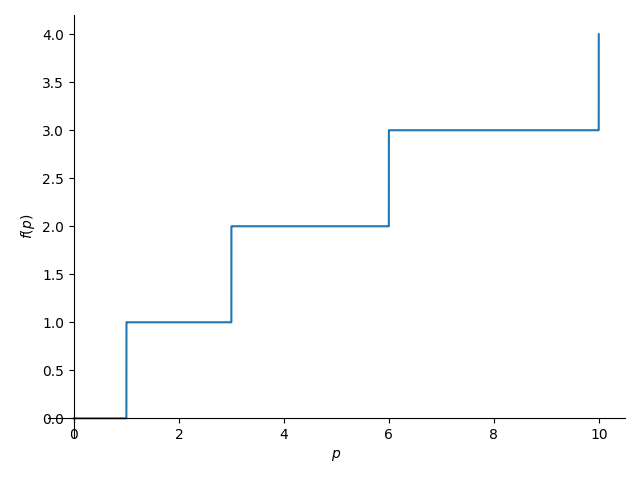

In [17]:
# Seems to work as expected, but I'd rather not calculate roots for each var pair.
# Maybe it is not a problem, especially for higher moments the cost would be minimal.
plot(sy.floor(index_to_row - 1), (_p, 0, 10))

In [18]:
# Insteaad of calculating by formula above we can pre-calculate row indices.
# only need to calculate this sequence once for the biggest accumulator matrix size (up to 5k elements, maybe slightly more).
# 2 options: calculate it in the GPU or calc it python and send it there.
def row_starts():
    p = 0
    i = 0
    while True:
        i += p
        yield i
        p += 1


starts = row_starts()
# Number of bits an index needs to support 5000x5000 triangle matrix
math.ceil(math.log2([next(starts) for _ in range(5001)][-1]))

24

In [19]:
# Convert the accumulator triangle matrix into a numpy matrix.
# Will need this for inspection / debugging.
# Alternative implementation of this procedure can use np.tril_indices()
def acc_to_numpy(nrows, acc):
    out = np.zeros((nrows, nrows), dtype=dtype)
    row_len = 1
    idx = 0
    for i in range(nrows):
        for j in range(row_len):
            out[i, j] = acc[idx]
            idx += 1
        row_len += 1
    return out

In [20]:
ck_pairs_update = cp.RawKernel(
    r"""
typedef double T;

extern "C" __global__
void update_pair(const int p, // Currently used also also as the cell size. 
               const int powers_idx_a, const int powers_idx_b, const int acc_idx, 
               const T* x_powers, T* acc) {
               
  // const int tid = blockDim.x * blockIdx.x + threadIdx.x; // DEBUG
  // printf("SUB <%d (b=%d, t=%d)> # %d \n", tid, blockIdx.x, threadIdx.x, p);
  
  for (int pa = 0; pa < p; pa++) {
    for (int pb = 0; pb < p; pb++) {
      // TODO Could probably cast T[p][p] cell = (T[p][p])(&acc[acc_idx]) for convenience.
      acc[acc_idx + pa * p + pb] += x_powers[powers_idx_a + pa] * x_powers[powers_idx_b + pb];
     }
  }
}

extern "C" __global__
void pairs_update(const int n, const int p, const int* row_indexes, const T* x_powers, T* acc) {
  const int tid = blockDim.x * blockIdx.x + threadIdx.x;
  printf("<%d (b=%d, t=%d)> # %d %d \n", tid, blockIdx.x, threadIdx.x, n, p);
  
  const int row_i = tid;
  const int next_row_i = row_indexes[row_i + 1];
  int acc_i = row_indexes[row_i];
  int col_i = 0;
  for (; acc_i < next_row_i; acc_i++) { 
    update_pair(p, row_i, col_i, acc_i, x_powers, acc);
  }
}
""",
    "pairs_update",
)

In [22]:
starts = row_starts()
row_index = np.array([next(starts) for _ in range(n + 1)], dtype=np.uint32)
print(row_index)
assert row_index[-1] == math.floor((n + 1) * n / 2)
cell_size = p

row_indexes = cp.array(row_index, dtype=cp.uint32)
acc = cp.zeros((row_index[-1] * cell_size,), dtype=dtype)

bs = min(ck_pairs_update.max_threads_per_block, n)
b = n // bs
if n % bs != 0:
    b += 1
print(b, bs)
ck_pairs_update(
    (b,), (bs,), (n, p, row_indexes, x_powers, acc)
)  # grid (number of blocks), block size and arguments
print(acc)
print(acc_to_numpy(n, acc))

[ 0  1  3  6 10 15]
1 5
[ 1.  1.  2.  3.  4.  5.  6.  7.  8.  9. 12. 16. 19. 24. 31. 37. 40. 48.
 56. 60. 64. 68. 72. 72. 72. 72. 64. 48. 32. 16.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.]
<0 (b=0, t=0)> # 5 4 
<1 (b=0, t=1)> # 5 4 
<2 (b=0, t=2)> # 5 4 
<3 (b=0, t=3)> # 5 4 
<4 (b=0, t=4)> # 5 4 
[[ 1.  0.  0.  0.  0.]
 [ 1.  2.  0.  0.  0.]
 [ 3.  4.  5.  0.  0.]
 [ 6.  7.  8.  9.  0.]
 [12. 16. 19. 24. 31.]]
